In [1]:
import torch
import matplotlib.pyplot as plt
from conex import Neocortex, prioritize_behaviors, SimpleDendriteStructure, SimpleDendriteComputation, SpikeTrace, \
    NeuronAxon, SynapseInit, WeightInitializer, SimpleDendriticInput, SimpleSTDP, Fire, WeightClip, LIF, \
    WeightNormalization, KWTA, ActivityBaseHomeostasis, VoltageBaseHomeostasis
from pymonntorch import NeuronGroup, NeuronDimension, SynapseGroup, EventRecorder, Recorder

from models.activity import ActivityRecorder
from models.dendrites import LateralDendriticInput2D, LateralInhibitionDendriticInput
from models.encoders import FeedDataset, CustomPoisson, Poisson
from models.learnings import PairedSTDPLocalVar, PairedRSTDPLocalVar
from models.trace import ClearSpikeTrace
from simulate import Simulation
from utils.dataset import load_data, add_overlap
from utils.formatter import pretty_format_dict
from utils.plots import add_colorized_raset_plot


# different parameters for Lateral Inhibition

### Change in current coef

In [2]:
INSTANCE_DURATION = 50
SLEEP = 10
dataset = load_data(directory='dataset/waterloo', resize_width=7, resize_height=7, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [3]:
INSTANCE_DURATION = 100
SLEEP = 15
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

sim1 = Simulation(net=Neocortex(dt=1))
input_layer = sim1.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim1.add_neuron_group(
    tag='output_layer_low',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim1.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.18,
                                        a_minus=0.055,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim1.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=100.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim1.initialize()
sim1.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(404)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

In [4]:
INSTANCE_DURATION = 100
SLEEP = 15
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

sim2 = Simulation(net=Neocortex(dt=1))
input_layer = sim2.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim2.add_neuron_group(
    tag='output_layer_normal',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim2.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.18,
                                        a_minus=0.055,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim2.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=50.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim2.initialize()
sim2.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(404)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

In [8]:
INSTANCE_DURATION = 100
SLEEP = 15
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

sim3 = Simulation(net=Neocortex(dt=1))
input_layer = sim3.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim3.add_neuron_group(
    tag='output_layer_high',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim3.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.18,
                                        a_minus=0.055,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim3.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=600.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim3.initialize()
sim3.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(404)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

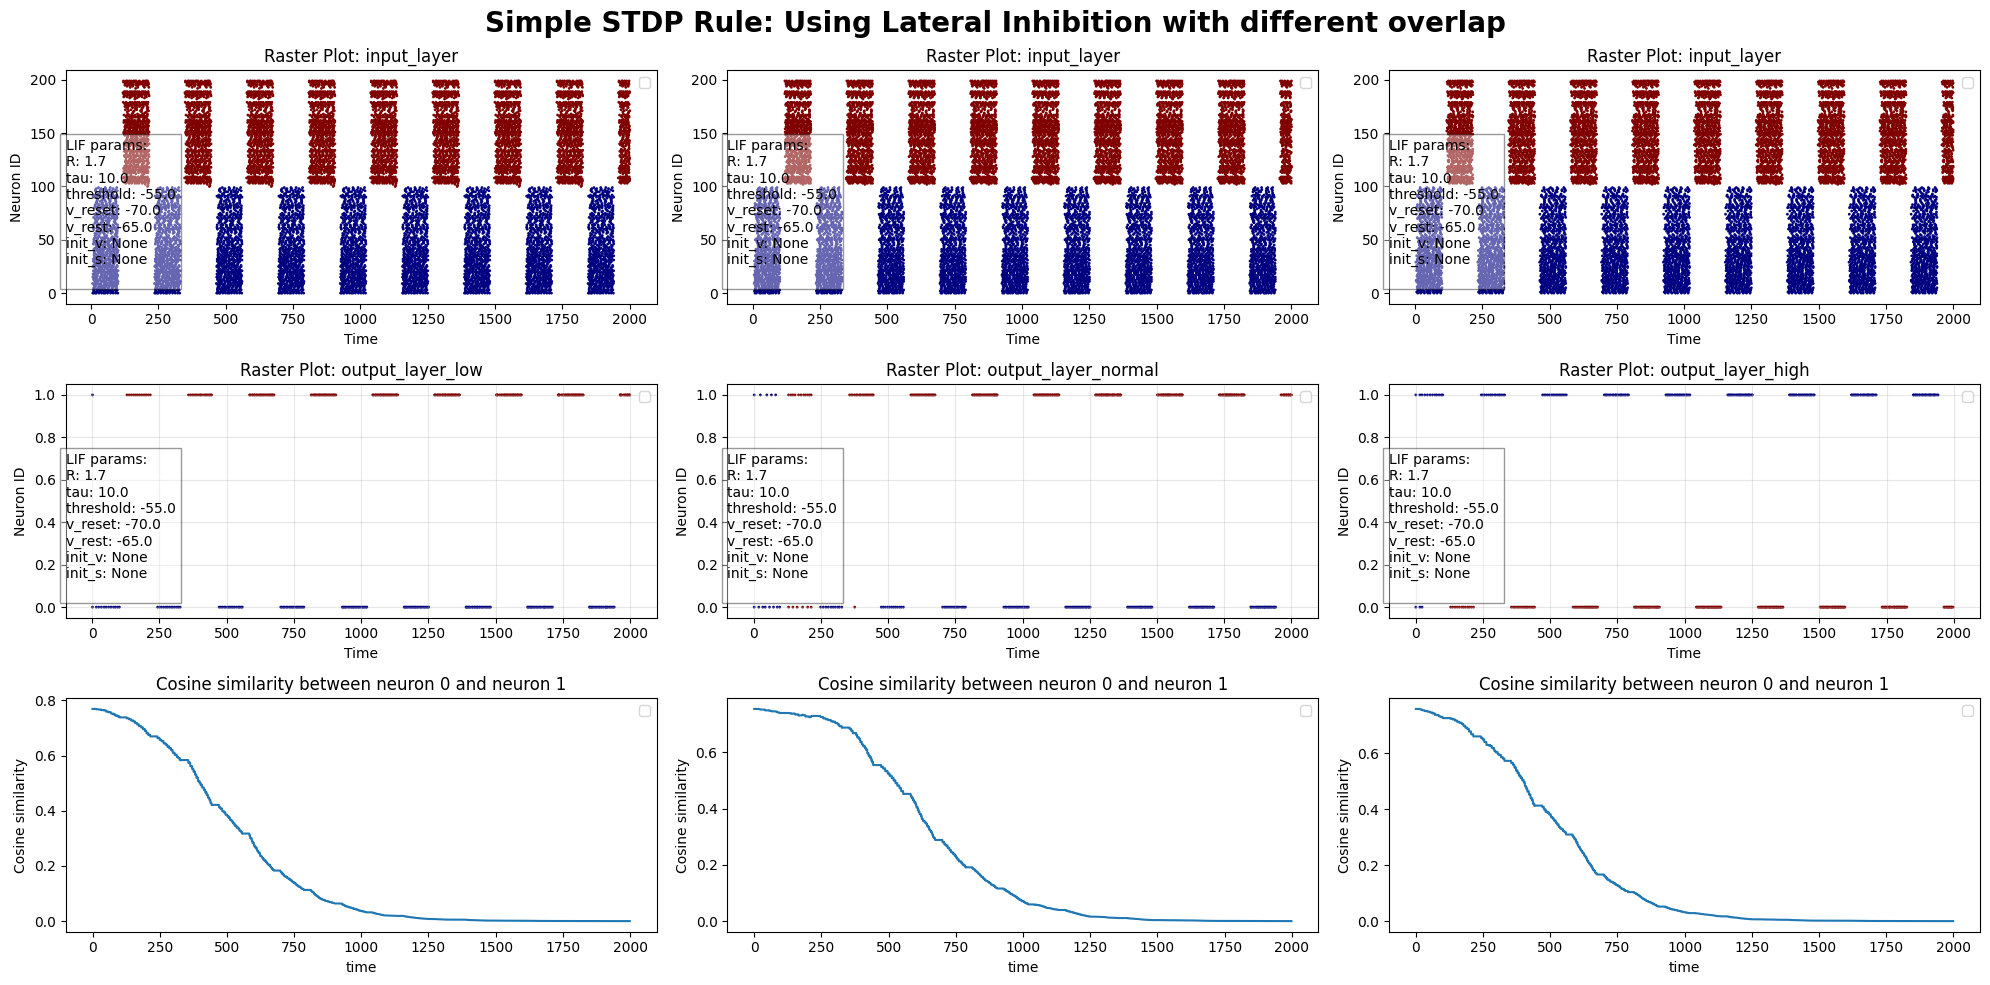

In [9]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(3, 3, 1)
add_colorized_raset_plot(ax1, sim1.net.NeuronGroups[0], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim1.net.NeuronGroups[0].add_neuron_model_params_info(ax1,text_y=0.1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 3, 2)
add_colorized_raset_plot(ax2, sim2.net.NeuronGroups[0], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim2.net.NeuronGroups[0].add_neuron_model_params_info(ax2,text_y=0.1, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 3, 3)
add_colorized_raset_plot(ax3, sim3.net.NeuronGroups[0], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim3.net.NeuronGroups[0].add_neuron_model_params_info(ax3,text_y=0.1, model_behavior_class=LIF)


ax4 = fig.add_subplot(3, 3, 4)
ax4.grid(True, alpha=0.3)
add_colorized_raset_plot(ax4, sim1.net.NeuronGroups[1], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim1.net.NeuronGroups[1].add_neuron_model_params_info(ax4,text_y=0.1, model_behavior_class=LIF)

ax5 = fig.add_subplot(3, 3, 5)
ax5.grid(True, alpha=0.3)
add_colorized_raset_plot(ax5, sim2.net.NeuronGroups[1], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim2.net.NeuronGroups[1].add_neuron_model_params_info(ax5,text_y=0.1, model_behavior_class=LIF)

ax6 = fig.add_subplot(3, 3, 6)
ax6.grid(True, alpha=0.3)
add_colorized_raset_plot(ax6, sim3.net.NeuronGroups[1], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim3.net.NeuronGroups[1].add_neuron_model_params_info(ax6,text_y=0.1, model_behavior_class=LIF)


ax7 = fig.add_subplot(3, 3, 7)
sim1.net.SynapseGroups[0].add_cosine_similarity_plot(ax7,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax8 = fig.add_subplot(3, 3, 8)
sim2.net.SynapseGroups[0].add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax9 = fig.add_subplot(3, 3, 9)
sim3.net.SynapseGroups[0].add_cosine_similarity_plot(ax9,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule: Using lateral inhibition: different coef", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition-different-overlap.pdf")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


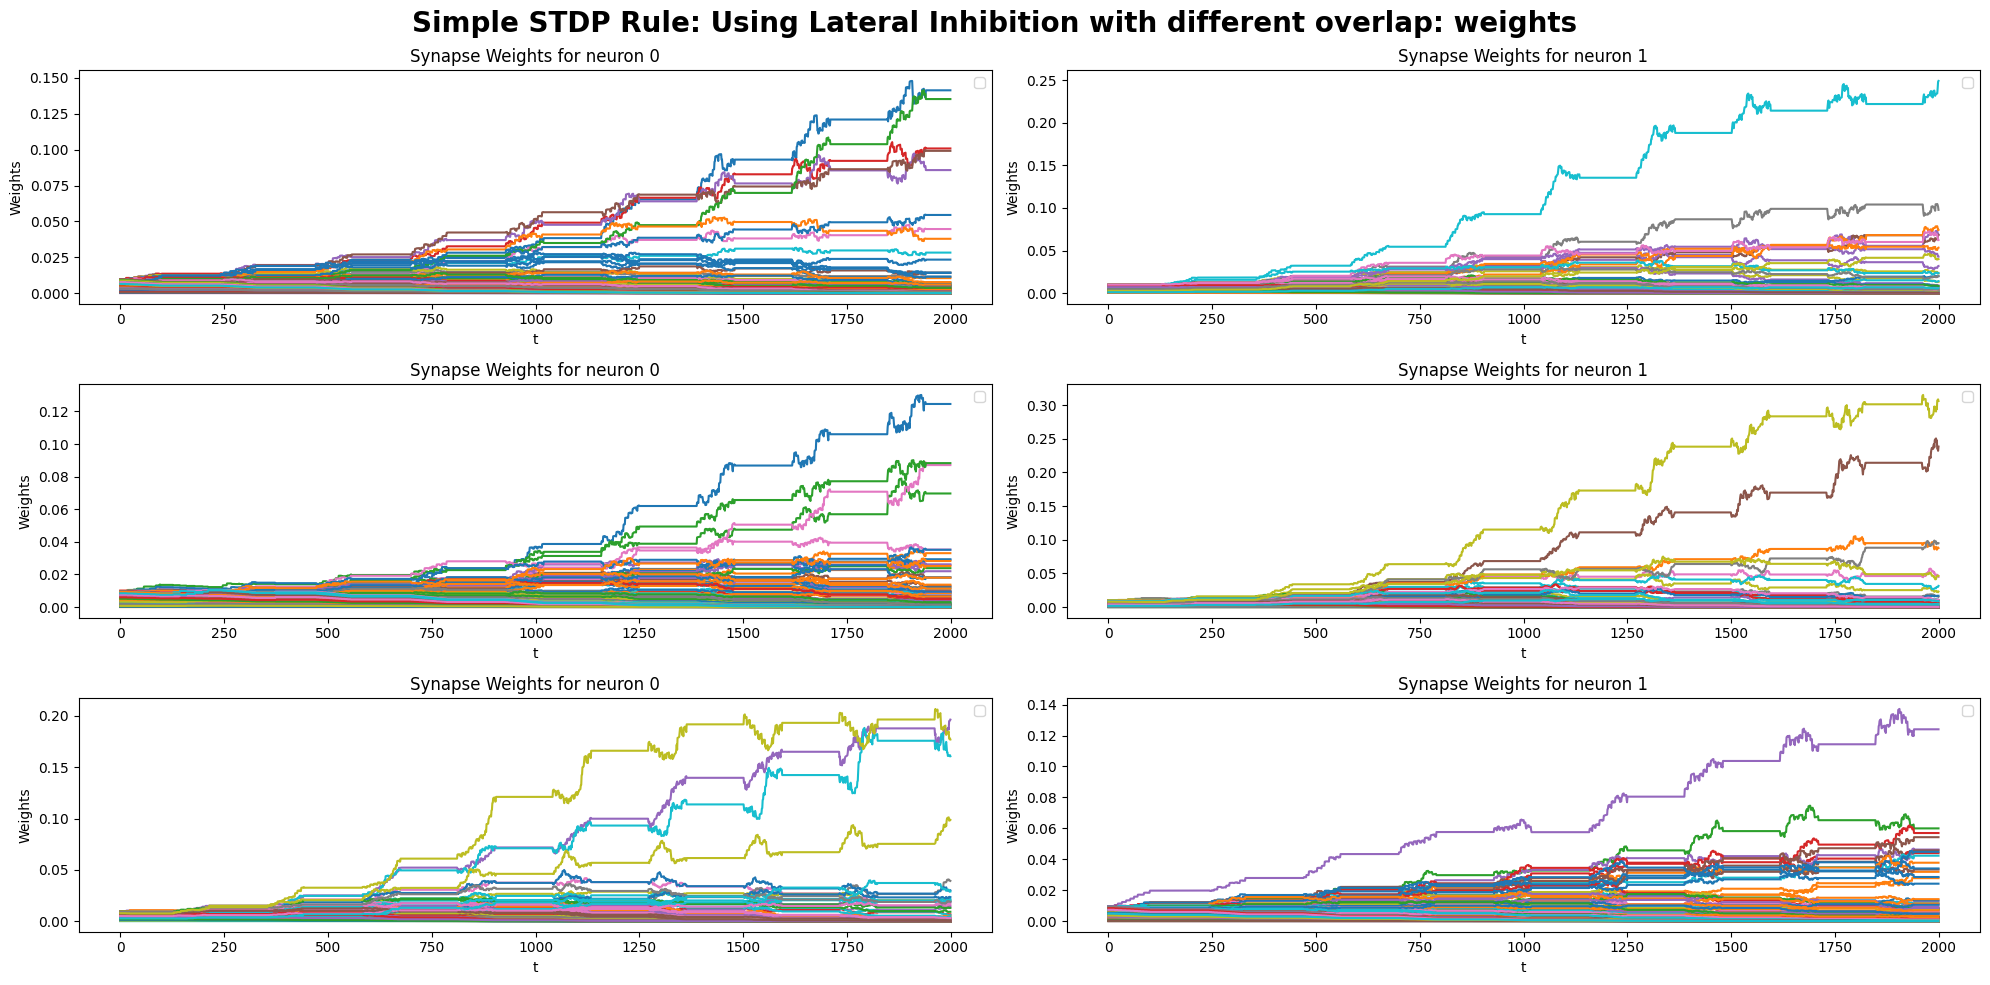

In [10]:
fig = plt.figure(figsize=(20, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)
sim1.net.SynapseGroups[0].add_weights_plot(ax1, recorder_behavior_class=Recorder, neuron_id=0)

ax2 = fig.add_subplot(3, 2, 2)
sim1.net.SynapseGroups[0].add_weights_plot(ax2, recorder_behavior_class=Recorder, neuron_id=1)

ax3 = fig.add_subplot(3, 2, 3)
sim2.net.SynapseGroups[0].add_weights_plot(ax3, recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
sim2.net.SynapseGroups[0].add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
sim3.net.SynapseGroups[0].add_weights_plot(ax5, recorder_behavior_class=Recorder, neuron_id=0)

ax6 = fig.add_subplot(3, 2, 6)
sim3.net.SynapseGroups[0].add_weights_plot(ax6, recorder_behavior_class=Recorder, neuron_id=1)
fig.suptitle("Simple STDP Rule: Using Lateral Inhibition with different overlap: weights", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition-different-overlap-weights.pdf")
plt.show()

# different parameters for KWTA

In [21]:
INSTANCE_DURATION = 50
SLEEP = 10
dataset = load_data(directory='dataset/waterloo', resize_width=7, resize_height=7, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [22]:
sim1 = Simulation(net=Neocortex(dt=1))
input_layer = sim1.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset.shape[1],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset, sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim1.add_neuron_group(
    tag='output_layer: k=0',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=dataset.shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=0)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim1.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=75.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.075,
                                        a_minus=0.025,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim1.initialize()
sim1.simulate_iterations(iterations=1000)

Network['Neocortex'](Neurons: tensor(100)|2 groups, Synapses: tensor(196)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](98){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False,  True, False],
         [False, False, False,

In [23]:
sim2 = Simulation(net=Neocortex(dt=1))
input_layer = sim2.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset.shape[1],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset, sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim2.add_neuron_group(
    tag='output_layer: k=1',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=dataset.shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim2.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=100.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.075,
                                        a_minus=0.025,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim2.initialize()
sim2.simulate_iterations(iterations=1000)

Network['Neocortex'](Neurons: tensor(100)|2 groups, Synapses: tensor(196)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](98){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False,  True, False],
         [False, False, False,

In [24]:
sim3 = Simulation(net=Neocortex(dt=1))
input_layer = sim3.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset.shape[1],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset, sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim3.add_neuron_group(
    tag='output_layer:k=2',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=dataset.shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=2)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim3.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=75.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.075,
                                        a_minus=0.025,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim3.initialize()
sim3.simulate_iterations(iterations=1000)

Network['Neocortex'](Neurons: tensor(100)|2 groups, Synapses: tensor(196)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](98){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False,  True, False],
         [False, False, False,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

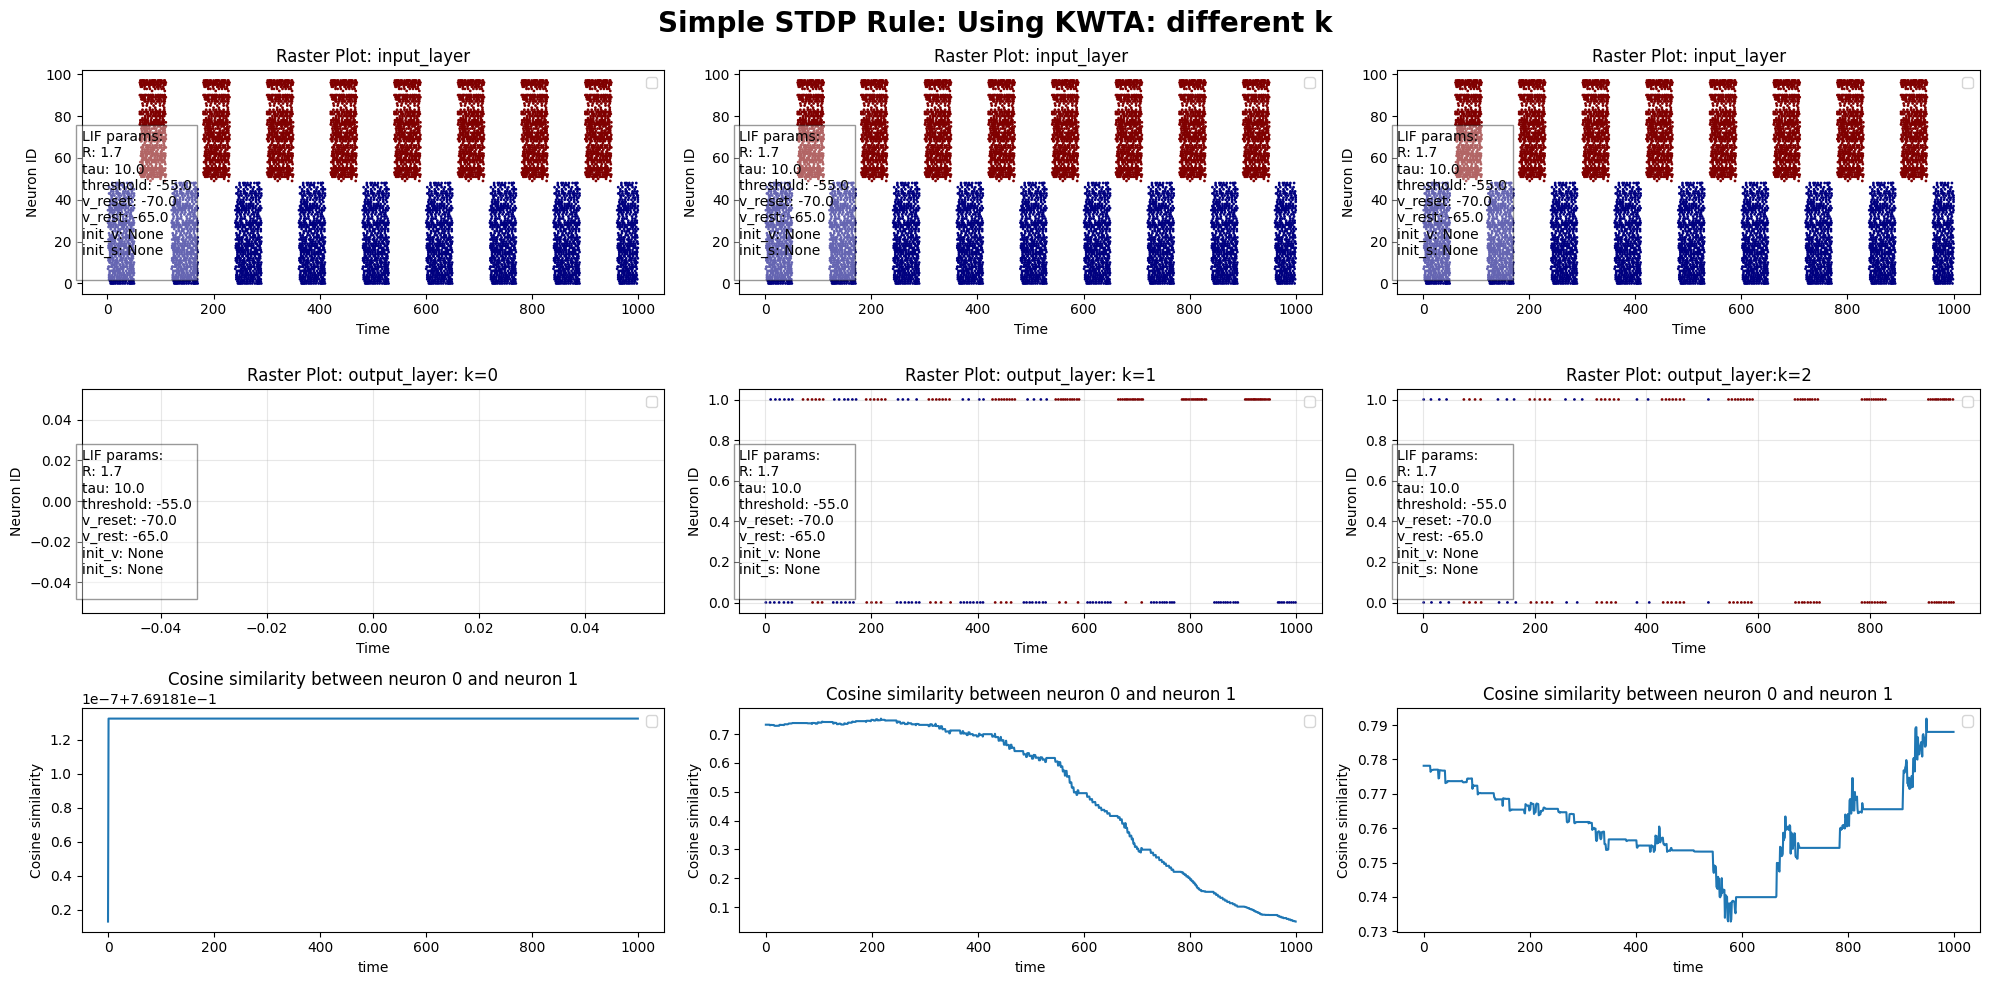

In [26]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(3, 3, 1)
add_colorized_raset_plot(ax1, sim1.net.NeuronGroups[0], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim1.net.NeuronGroups[0].add_neuron_model_params_info(ax1,text_y=0.1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 3, 2)
add_colorized_raset_plot(ax2, sim2.net.NeuronGroups[0], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim2.net.NeuronGroups[0].add_neuron_model_params_info(ax2,text_y=0.1, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 3, 3)
add_colorized_raset_plot(ax3, sim3.net.NeuronGroups[0], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim3.net.NeuronGroups[0].add_neuron_model_params_info(ax3,text_y=0.1, model_behavior_class=LIF)


ax4 = fig.add_subplot(3, 3, 4)
ax4.grid(True, alpha=0.3)
add_colorized_raset_plot(ax4, sim1.net.NeuronGroups[1], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim1.net.NeuronGroups[1].add_neuron_model_params_info(ax4,text_y=0.1, model_behavior_class=LIF)

ax5 = fig.add_subplot(3, 3, 5)
ax5.grid(True, alpha=0.3)
add_colorized_raset_plot(ax5, sim2.net.NeuronGroups[1], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim2.net.NeuronGroups[1].add_neuron_model_params_info(ax5,text_y=0.1, model_behavior_class=LIF)

ax6 = fig.add_subplot(3, 3, 6)
ax6.grid(True, alpha=0.3)
add_colorized_raset_plot(ax6, sim3.net.NeuronGroups[1], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim3.net.NeuronGroups[1].add_neuron_model_params_info(ax6,text_y=0.1, model_behavior_class=LIF)


ax7 = fig.add_subplot(3, 3, 7)
sim1.net.SynapseGroups[0].add_cosine_similarity_plot(ax7,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax8 = fig.add_subplot(3, 3, 8)
sim2.net.SynapseGroups[0].add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax9 = fig.add_subplot(3, 3, 9)
sim3.net.SynapseGroups[0].add_cosine_similarity_plot(ax9,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule: Using KWTA: different k", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part3-simple-stdp-kwta-different-k.pdf")
plt.show()

### Different in k: Lateral Inhibition + K

In [32]:
INSTANCE_DURATION = 50
SLEEP = 10
dataset = load_data(directory='dataset/waterloo', resize_width=7, resize_height=7, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [33]:
INSTANCE_DURATION = 100
SLEEP = 15
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

sim1 = Simulation(net=Neocortex(dt=1))
input_layer = sim1.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim1.add_neuron_group(
    tag='output_layer: k=0',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=0)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim1.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.18,
                                        a_minus=0.055,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim1.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim1.initialize()
sim1.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(404)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

In [34]:
INSTANCE_DURATION = 100
SLEEP = 15
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

sim2 = Simulation(net=Neocortex(dt=1))
input_layer = sim2.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim2.add_neuron_group(
    tag='output_layer: k=1',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim2.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.18,
                                        a_minus=0.055,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim2.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=50.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim2.initialize()
sim2.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(404)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

In [35]:
INSTANCE_DURATION = 100
SLEEP = 15
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

sim3 = Simulation(net=Neocortex(dt=1))
input_layer = sim3.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim3.add_neuron_group(
    tag='output_layer: k=2',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=2)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim3.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_plus=0.18,
                                        a_minus=0.055,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim3.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim3.initialize()
sim3.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(404)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

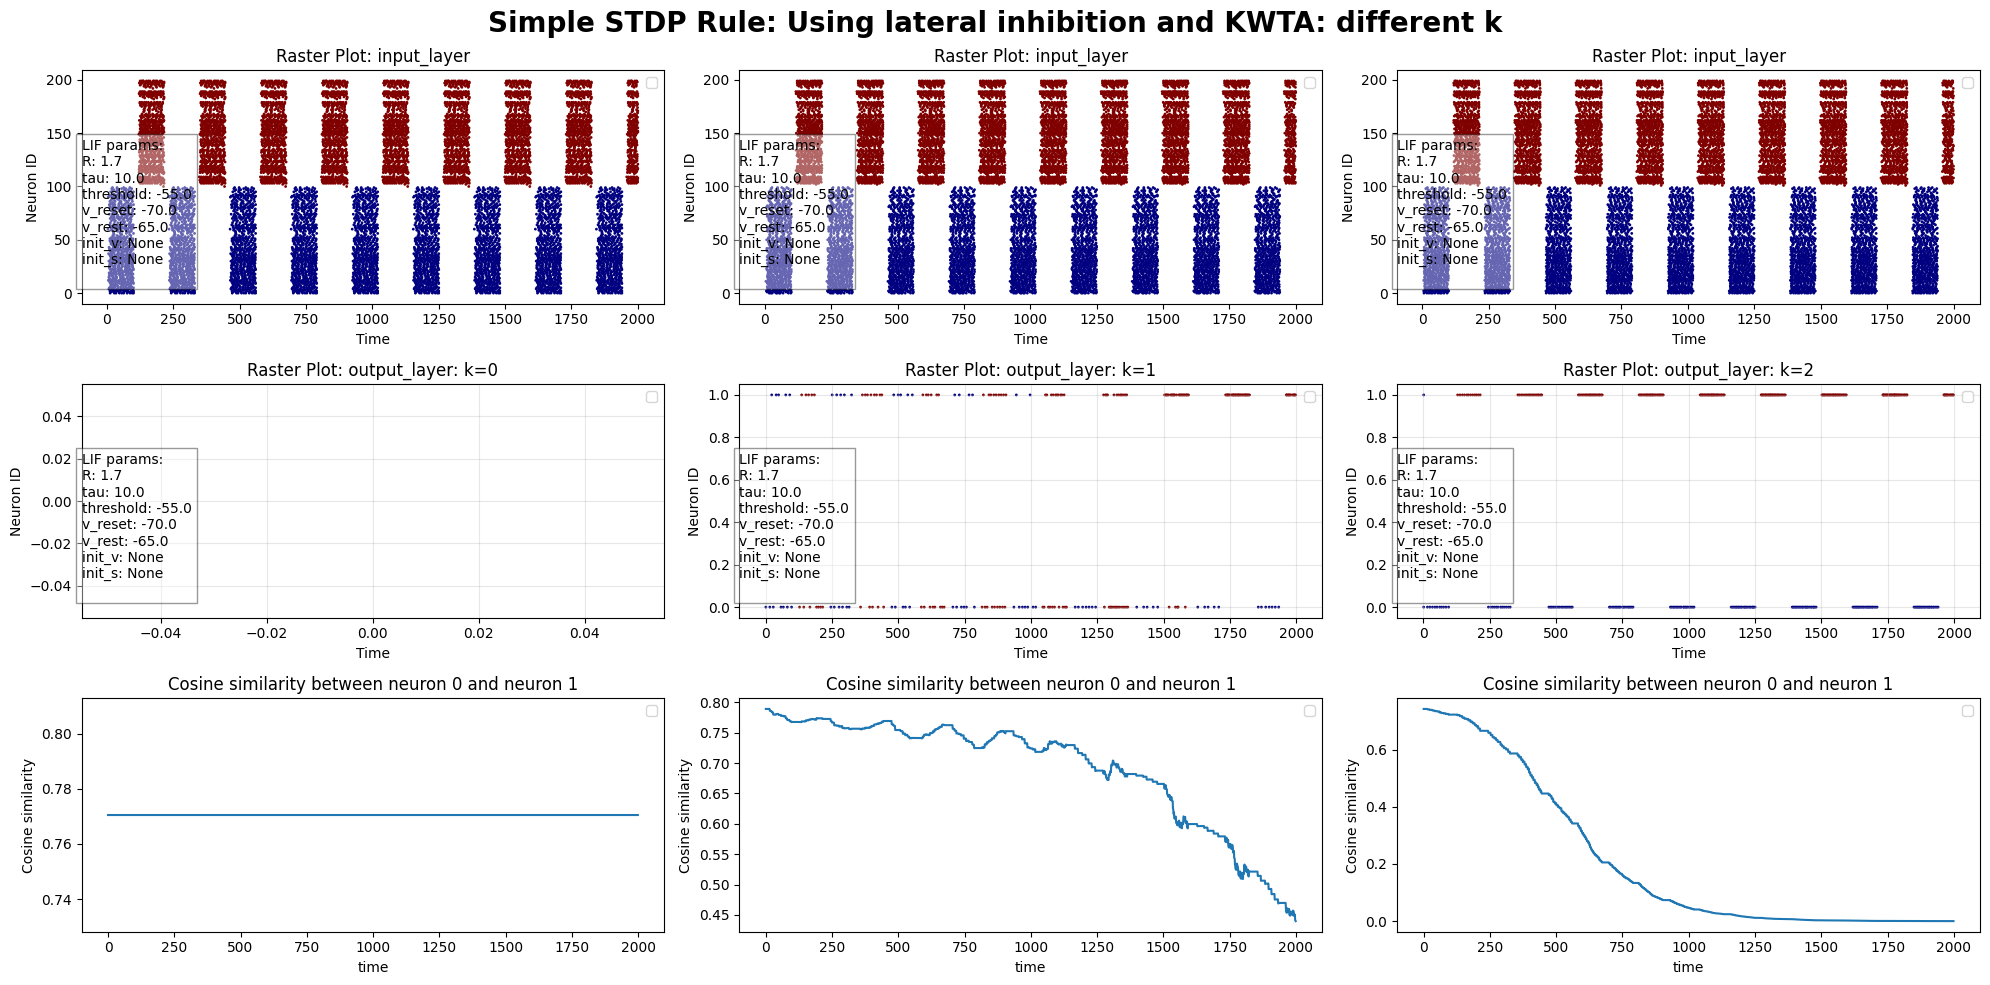

In [36]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(3, 3, 1)
add_colorized_raset_plot(ax1, sim1.net.NeuronGroups[0], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim1.net.NeuronGroups[0].add_neuron_model_params_info(ax1,text_y=0.1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 3, 2)
add_colorized_raset_plot(ax2, sim2.net.NeuronGroups[0], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim2.net.NeuronGroups[0].add_neuron_model_params_info(ax2,text_y=0.1, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 3, 3)
add_colorized_raset_plot(ax3, sim3.net.NeuronGroups[0], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim3.net.NeuronGroups[0].add_neuron_model_params_info(ax3,text_y=0.1, model_behavior_class=LIF)


ax4 = fig.add_subplot(3, 3, 4)
ax4.grid(True, alpha=0.3)
add_colorized_raset_plot(ax4, sim1.net.NeuronGroups[1], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim1.net.NeuronGroups[1].add_neuron_model_params_info(ax4,text_y=0.1, model_behavior_class=LIF)

ax5 = fig.add_subplot(3, 3, 5)
ax5.grid(True, alpha=0.3)
add_colorized_raset_plot(ax5, sim2.net.NeuronGroups[1], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim2.net.NeuronGroups[1].add_neuron_model_params_info(ax5,text_y=0.1, model_behavior_class=LIF)

ax6 = fig.add_subplot(3, 3, 6)
ax6.grid(True, alpha=0.3)
add_colorized_raset_plot(ax6, sim3.net.NeuronGroups[1], time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
sim3.net.NeuronGroups[1].add_neuron_model_params_info(ax6,text_y=0.1, model_behavior_class=LIF)


ax7 = fig.add_subplot(3, 3, 7)
sim1.net.SynapseGroups[0].add_cosine_similarity_plot(ax7,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax8 = fig.add_subplot(3, 3, 8)
sim2.net.SynapseGroups[0].add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax9 = fig.add_subplot(3, 3, 9)
sim3.net.SynapseGroups[0].add_cosine_similarity_plot(ax9,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule: Using lateral inhibition and KWTA: different k", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part3-simple-stdp-lateral-inhibition-kwta-different-k.pdf")
plt.show()

# different parameters for Activity base homeostasis